# Laboratorio 4

Sean bienvenidos de nuevo al laboratorio 4 de Deep Learning y Sistemas Inteligentes. Así como en los laboratorios pasados, espero que esta ejercitación les sirva para consolidar sus conocimientos en el tema de Encoder-Decoder y AutoEnconders.

Para este laboratorio estaremos usando una herramienta para Jupyter Notebooks que facilitará la calificación, no solo asegurándo que ustedes tengan una nota pronto sino también mostrandoles su nota final al terminar el laboratorio.

Espero que esta vez si se muestren los *marks*. De nuevo me discupo si algo no sale bien, seguiremos mejorando conforme vayamos iterando. Siempre pido su comprensión y colaboración si algo no funciona como debería.

Al igual que en el laboratorio pasado, estaremos usando la librería de Dr John Williamson et al de la University of Glasgow, además de ciertas piezas de código de Dr Bjorn Jensen de su curso de Introduction to Data Science and System de la University of Glasgow para la visualización de sus calificaciones.

**NOTA:** Ahora tambien hay una tercera dependecia que se necesita instalar. Ver la celda de abajo por favor

<script type="text/javascript" src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML">
</script>

In [2]:
# Una vez instalada la librería por favor, recuerden volverla a comentar.
!pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master
!pip install scikit-image
!pip install -U --force-reinstall --no-cache https://github.com/AlbertS789/lautils/zipball/master

     - 119.1 kB 31.5 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jhwutils: filename=jhwutils-1.3-py3-none-any.whl size=41854 sha256=8e3596f34dad4d5f9b530b109daa0cf3395562ecb15684953eab9b1689baacd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-68_hp9k2/wheels/a8/e7/e3/9542f8e4159ba644c6acd9f78babbe8489bb72667fb02ac54d
Successfully built jhwutils
  Attempting uninstall: jhwutils
    Found existing installation: jhwutils 1.3
    Uninstalling jhwutils-1.3:
      Successfully uninstalled jhwutils-1.3
     - 4.2 kB ? 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lautils: filename=lautils-1.0-py3-none-any.whl size=2826 sha256=e3f8eb03c72f11aca33a0da80494ead8f571d4c01a2bc92b74ca1a477737280e
  Stored in directory: /tmp/pip-ephem-wheel-cache-tcwfmah9/wheels/1a/50/ba/b3ceb937949f5894a896b68af5b5fdb598e50244141063e4db
Successfully built lautils
  Attempting uninstall: lautils
    Found existing installation: lautils 1.0
    Uninstalling laut

In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import os
from collections import defaultdict

#from IPython import display
#from base64 import b64decode


# Other imports
from unittest.mock import patch
from uuid import getnode as get_mac

from jhwutils.checkarr import array_hash, check_hash, check_scalar, check_string, array_hash, _check_scalar
import jhwutils.image_audio as ia
import jhwutils.tick as tick
from lautils.gradeutils import new_representation, hex_to_float, compare_numbers, compare_lists_by_percentage, calculate_coincidences_percentage

###
tick.reset_marks()

%matplotlib inline

In [4]:
# Seeds
seed_ = 2023
np.random.seed(seed_)

In [5]:
# Celda escondida para utlidades necesarias, por favor NO edite esta celda


###### Información del estudiante en dos variables

* carne_1 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_1: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)
* carne_2 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_2: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)

In [6]:
carne_1 = "22434"
firma_mecanografiada_1 = "Nelson García"
carne_2 = "22296"
firma_mecanografiada_2 = "Joaquín Puente"
# YOUR CODE HERE


In [7]:
# Deberia poder ver dos checkmarks verdes [0 marks], que indican que su información básica está OK

with tick.marks(0):
    assert(len(carne_1)>=5 and len(carne_2)>=5)

with tick.marks(0):
    assert(len(firma_mecanografiada_1)>0 and len(firma_mecanografiada_2)>0)

## Parte 1 - Word2Vec

**Créditos:** La primera parte de este laboratorio está tomado y basado en uno de los post de Musashi (Jacobs-) Harukawa

La eficacia de las técnicas de embedding está directamente relacionada con los desafíos iniciales que motivaron los enfoques de texto como datos. Al convertir el lenguaje natural en representaciones numéricas, los métodos de incrustación abren oportunidades para aplicar varias herramientas cuantitativas a fuentes de datos previamente sin explotar.

En términos generales, word embedding representa cada palabra en un conjunto dado de textos (corpus) como vectores en un espacio k-dimensional (donde k es elegido por el investigador; más detalles sobre esto más adelante). Estos vectores contienen información valiosa sobre las relaciones de las palabras y su contexto, sirviendo como herramientas esenciales para las tareas posteriores de modelado del lenguaje.

Entonces, es entendible que se pregunten

* ¿Cómo funciona este proceso de incrustación?
* ¿Cuál es la razón subyacente de su éxito?
* ¿Cómo podemos determinar su eficacia?

Para poder responder las primeras dos preguntas, vamos a implementar este modelo usando PyTorch. Noten que el state-of-the-art ya no solo se usa Word2Vec, como BERT (Bidirectional Encoder Representations from Transformers). Pero siempre es un buen ejercicio entender estos algoritmos.

### Paso 1 - DataLoader

Como en laboratorios, lo primero que necesitamos es definir un DataLoader. Para esta primera parte estaremos usando el dataset llamado "tweets_hate_speech_detection" de HugginFace.

Para esto necesitamos una función que separe los textos en listas de tokens. El preprocesamiento para cuando se trabaja con textos debe ser un poco más exhaustivo de lo que haremos en este laboratorio, pero para fines del mismo solamente haremos:

1- Pasar a minusculas

2- Quitar todos los simbolos diferentes de a-z@#

3- Separar en espacios

4- Quitar "stopword" y tokens vacíos

5- Aplicar snowball stemmer al resto (snowball? sí, refieran a la nota de abajo para la explicación rápida)

Para esto nos apoyaremos en el paquete de natural language processing toolkit o nltk para los cuates. Entonces, recuerden instalarlo por favor "pip install nltk"

**Snowball Stemmer** es un modulo en la librería NLTK que implementa la técnica de stemming. ¿Stemming?
Stemming es una técnica utilizada para extraer la forma base de las palabras mediante la eliminación de los (pre-post)fijos de ellos. Imaginen que cortan la ramas de un árbol hasta los tallos. Por ejemplo, la raíz de las palabras comiendo, come, comido es comer. Refieran a este [link](https://www.tutorialspoint.com/natural_language_toolkit/natural_language_toolkit_stemming_lemmatization.htm) para más información

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
import torch
import datasets

dataset = datasets.load_dataset('tweets_hate_speech_detection')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17197 [00:00<?, ? examples/s]

In [10]:
# Para simplicidad quitemos characteres pero mantegamos @ y #
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

ss = SnowballStemmer('english')
sw = stopwords.words('english')

#def split_tokens(row):                             # PASO
#    row['all_tokens'] = [ss.stem(i) for i in       # 5
#                     re.split(r" +",               # 3
#                     re.sub(r"[^a-z@# ]", "",      # 2
#                            row['tweet'].lower())) # 1
#                     if (i not in sw) and len(i)]  # 4
#    return row

def split_tokens(row):
    # 1- Pasar a minusculas
    tweet_lower = row['tweet'].lower()

    # 2- Quitar todos los simbolos diferentes de a-z@#
    tweet_cleaned = re.sub(r"[^a-z@# ]", "", tweet_lower)

    # 3- Separar en espacios
    tweet_tokens = re.split(r" +", tweet_cleaned)

    # 4- Quitar "stopword" y tokens vacíos
    # 5- Aplicar snowball stemmer al resto
    filtered_tokens = [ss.stem(i) for i in tweet_tokens if (i not in sw) and len(i)]


    row['all_tokens'] = filtered_tokens

    return row

In [11]:
# Determinamos el vocabulario
dataset = dataset.map(split_tokens)

Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

Ahora podemos crear algunas variables que nos serán útiles en futuros pasos. Además, debemos quitar los tokens que ocurren menos de 10 veces para reducir el tamaño del vocabulario

In [12]:
from collections import Counter

# Total de palabras

counts = Counter([i for s in dataset['train']['all_tokens'] for i in s])
counts = {k:v for k, v in counts.items() if v>10} # Filtering

#Obtener tokens únicos (vocabulario filtrado)
vocab = list(counts.keys())
n_v = len(vocab)

# Tamaño del vocabulario
vocab_size = len(vocab)
print(f"Tamaño del vocabulario: {vocab_size}")

# Diccionarios de mapeo token <-> id
id2tok = dict(enumerate(vocab))
tok2id = {tok: idx for idx, tok in id2tok.items()}

# Funcion para quitar tokens "raros"
def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row

dataset = dataset.map(remove_rare_tokens)

Tamaño del vocabulario: 3085


Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet', 'all_tokens', 'tokens'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet', 'all_tokens', 'tokens'],
        num_rows: 17197
    })
})

In [14]:
with tick.marks(3):
    assert(check_scalar(len(counts), '0xf4f4eb83'))

with tick.marks(3):
    assert(check_scalar(len(id2tok), '0xf4f4eb83'))

with tick.marks(3):
    assert(check_scalar(len(vocab), '0xf4f4eb83'))

with tick.marks(3):
    assert(check_scalar(n_v, '0xf4f4eb83'))

with tick.marks(3):
    assert(check_scalar(tok2id['father'], '0xb44c37ea'))

with tick.marks(3):
    assert(check_string(id2tok[1], '0xcf2531b8'))

Ahora, recordemos que Word2Vec ayuda a representar una palabra por su contexto, para ello necesitamos definir una ventana movil (sliding window) que se usa dentro del algoritmo. Esta consiste en tomar cada palabra de una frase, y luego se parea con las N palabras más cercanas (hacia la derecha e izquierda). Por ejemplo, consideremos una frase como "every good dog does fine", con una ventana de 2. El resultado sería algo como:

`(every, good)`
`(every, dog)`
`(good, every)`
`(good, dog)`
`(good, does)`
`(dog, every)`
`(dog, good)`
`...`

Y así consecutivamente. La frase u oración, es convertida en un par `target, context` donde el contex es una lista de tokens dentro de la ventana.

Luego, definiremos el DataSet usando las clases correspondiente como lo hemos hecho antes.

In [15]:
#def windowizer(row, wsize=3):
#    """
#    Windowizer function for Word2Vec. Converts sentence to sliding-window
#    pairs.
#    """
#    doc = row['tokens']
#    #wsize = 3
#    out = []
#    for i, word in enumerate(doc):
#        target = tok2id[word]
#        window = [i+j for j in
#                  range(-wsize, wsize+1, 1)
#                  if (i+j>=0) &
#                     (i+j<len(doc)) &
#                     (j!=0)]
#
#        out += [(target, tok2id[doc[w]]) for w in window]
#    row['moving_window'] = out
#    return row


def windowizer(row, wsize=3):
    """
    Windowizer function for Word2Vec. Converts sentence to sliding-window
    pairs.
    """
    doc = row['tokens']
    out = []

    for i, word in enumerate(doc):
        target = tok2id[word]

        # 1 - Definimos el rango de la ventana movil
        window = [i + j for j in range(-wsize, wsize + 1, 1) if (i + j >= 0) & (i + j < len(doc)) & (j != 0)]

        # 2 - Creamos pares de la ventana movil
        window_pairs = [(target, tok2id[doc[w]]) for w in window]

        # 3 - Agregamos los pares a la lista de salida
        out += window_pairs

    # 4 - Asignamos el "moving_window" a la fila
    row['moving_window'] = out

    return row

# Aplicar la función al dataset
dataset = dataset.map(windowizer)


Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

In [16]:
with tick.marks(5):
    assert(check_scalar(dataset["train"].num_rows, '0xcd61d16b'))

In [17]:
#from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader


class Word2VecDataset(Dataset):
    def __init__(self, dataset, vocab_size, wsize=3):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset['moving_window'] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx][0], self.data[idx][1]


Ahora definiremos dos variables globales, el `BATCH_SIZE` y `N_LOADER_PROCS`.

`BATCH_SIZE` es el número de observaciones devueltas con cada llamada. Gran parte de las aceleraciones del procesamiento de GPU provienen de cálculos de matriz por batches masivos. Al elegir el tamaño del batch, recuerden que generalmente se trata de un trade-off entre el uso de VRAM y la velocidad, excepto cuando el Data Loader en sí es el cuello de botella. Para acelerar el DataLoader, podemos pasar un argumento a num_workers para habilitar la paralelización en la preparación y carga de datos.

In [18]:

# Create an instance of the Word2VecDataset
word2vec_dataset_ = Word2VecDataset(dataset['train'], vocab_size=n_v)

# Convert the Word2VecDataset into a TensorDataset
word2vec_dataset = TensorDataset(torch.tensor(word2vec_dataset_.data, dtype=torch.long))

BATCH_SIZE = 2**16
N_LOADER_PROCS = 5

dataloader_train = DataLoader(word2vec_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_LOADER_PROCS)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Paso 2 - Construyendo la Red
La arquitectura que usaremos para esta ocasión será la dada por una versión de Word2Vec, esta consiste en:
* Tres capas: Input, hidden y output
* Tanto el tamaño de la input como la output son del tamaño del vocabulario. Pero la hidden es un poco más pequeña
* Todas son Fully Connected con Funciones de Activación Lineales

Como mencionamos en clase hay dos variantes
* CBOW (Continuous Bag of Words): El enfoque está dado en las palabras de contexto para dar énfasis a la palabra central. O en otras palabras, las palabras de contexto son el input y la palabra central son el output (Espero que esto haga más sentido de la explicación en clase)
* Skip-gram: La palabra central es el input, y las de contexto son la salida.

Definamos CBOW para este laboratorio...

Pero antes, debemos encodear nuestras palabras (otra vez como lo hicimos en el laboratorio pasado), esta implementación es similar a la que hicimos anteriormente, pero observen el uso de tensores.

In [19]:
from torch import nn

size = 20
input_ = 7

def one_hot_encode(input_, size):
    vec = torch.zeros(size).float()
    vec[input_] = 1.0  # Aquí se marca la posición como activa
    return vec

ohe = one_hot_encode(input_, size)
linear_layer = nn.Linear(size, 1, bias=False)

In [20]:
with tick.marks(3):
    assert int(ohe[7])  == 1

Ahora, sobreescribamos el comportamiento natural de la inicializacion de pesos, para que estos en lugar de iniciar aleatoriamente, sean valores de 0 - size. Esto lo hacemos dentro `torch.no_grad()` para quitar el tracking de la gradiente (recuerden que cuando usamos los tensores de PyTorch la gradiente se le hace tracking, es decir que se almacenan para hacer la diferenciar la pérdida con respecto de cada parametro en el modelo. Debido a que en esta ocasion lo estamos seteando manualmente no queremos que se almacene y sea considerado en futuras backpropagations.

Observen como al pasar el vector encodeado a la capa nos devuelve efectivamente el número que corresponde en `linear_layer(ohe)`

In [21]:
with torch.no_grad():
    linear_layer.weight = nn.Parameter(
        torch.arange(size, dtype=torch.float).reshape(linear_layer.weight.shape))

print(linear_layer.weight)
print(linear_layer(ohe))

Parameter containing:
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19.]], requires_grad=True)
tensor([7.], grad_fn=<SqueezeBackward4>)


Ya que tenemos un mejor entendimiento de este tipo de layers en Word2Vec, debemos saber que PyTorch tiene una implementación más eficiente usando `nn.Embedding`, el cual toma los índices de input y regresa el peso del borde correspondiente a ese índice.

Un equivalente a lo que hemos hecho anteriormente sería lo que se presenta en la siguiente celda.

Noten como volvemos a obtener un tensor similar al que obtuvimos antes.

In [22]:
embedding_layer = nn.Embedding(size, 1)

with torch.no_grad():
    embedding_layer.weight = nn.Parameter(
        torch.arange(size, dtype=torch.float
        ).reshape(embedding_layer.weight.shape))

print(embedding_layer.weight)
print(embedding_layer(torch.tensor(input_)))

Parameter containing:
tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.]], requires_grad=True)
tensor([7.], grad_fn=<EmbeddingBackward0>)


Con esto en consideración, es momento de implementar nuestro modelo Word2Vec.

Noten el embedding_size, este corresponde a la cantidad de representaciones de cada palabra, como dijimos en clase, esto sería la cantidad de funciones de activaciones con las que trabajaremos.

Además, consideren las siguientes explicaciones

`self.embed`: Es una capa de embedding para convertir la entrada (el índice del token de centro/contexto) en la codificación one-hot, y luego recuperar los pesos correspondientes a estos índices en la capa hidden de menor dimensión.

`self.expand`: Es una capa lineal para predecir la probabilidad de una palabra de centro/contexto dada la hidden layer. Deshabilitamos el bias (la intercepción) porque cambiamos la escala de nuestras predicciones de todos modos.

`logits`: Este vuelve a expandir la capa hidden para hacer predicciones. Estas predicciones sin procesar deben volver a escalarse con softmax, pero omitimos este paso aquí, ya que PyTorch implementa los pasos relevantes en la Cross Entropy loss.

In [23]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input_):
        # Pasamos el input a una representación más pequeña
        hidden = self.embed(input_)
        # Expandemos hacia las predicciones
        logits = self.expand(hidden)
        return logits

### Paso 3 - Entrenamiento (Training)


El entrenamiento en el contexto de las redes neuronales significa hacer predicciones repetidamente utilizando las observaciones en el conjunto de datos y luego ajustar los parámetros para corregir el error en las predicciones.

Debido a que no queremos que la red aprenda perfectamente la predicción más reciente mientras olvida todas las demás predicciones, generalmente le damos un "learning rate", que es una penalización en el ajuste de pérdida para evitar que se ajuste solo a la observación más reciente. (Recuerden como funciona backpropgation)

Cuanto más tiempo entrenemos la red, con mayor perfección aprenderá los datos de entrenamiento, pero a menudo esto conlleva el riesgo de overfitting y no poder generalizar a datos no vistos. Sin embargo, dado que con Word2Vec nuestro objetivo no es inferir datos no vistos, sino describir datos "vistos", ¿cuál creen que es la implicación del overfitting en este tipo de modelos? (Más adelante se deja nuevamente la pregunta para que sea respondida)

In [24]:
# Algunos hyper parametros

# Demasiado pequeño pero es solo para fines de aprendizaje
EMBED_SIZE = 50
model = Word2Vec(n_v, EMBED_SIZE)

# Traten de usar ya el CUDA si pueden por favor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using:",device)
model.to(device)

# Otros parametros para el training
LR = 3e-4
EPOCHS = 3
loss_fn = nn.CrossEntropyLoss()
# Noten el tipo de optimizador que estamos usando :)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

Using: cuda


In [25]:
running_loss = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    losses = []

    for ix, batch in enumerate(dataloader_train):
        print(f"Working with batch {ix}")
        for i in range(len(batch[0])):
            center = batch[0][i][0]
            context = batch[0][i][1]
            center, context = center.to(device), context.to(device)

            # ZEROS gradients acumuladas
            optimizer.zero_grad()

            # FORWARD pass (predice la palabra objetivo dado el contexto)
            logits = model(input_=context).unsqueeze(0)

            # CALCULAR pérdida entre la predicción y la palabra central real
            loss = loss_fn(logits, center.unsqueeze(0))  # .unsqueeze para shape correcto

            losses.append(loss.item())

            # BACKPROPAGATION
            loss.backward()
            optimizer.step()

            if i % 6500 == 0:
                print(f"Done working with element {i}")

    epoch_loss = np.mean(losses)
    running_loss.append(epoch_loss)

    # Mostrar la perdida cada N epocas
    if epoch % 1 == 0:
        print(f'Epoca {epoch}, loss: {epoch_loss}')

Working with batch 0
Done working with element 0
Done working with element 6500
Done working with element 13000
Done working with element 19500
Done working with element 26000
Done working with element 32500
Done working with element 39000
Done working with element 45500
Done working with element 52000
Done working with element 58500
Done working with element 65000
Working with batch 1
Done working with element 0
Done working with element 6500
Done working with element 13000
Done working with element 19500
Done working with element 26000
Done working with element 32500
Done working with element 39000
Done working with element 45500
Done working with element 52000
Done working with element 58500
Done working with element 65000
Working with batch 2
Done working with element 0
Done working with element 6500
Done working with element 13000
Done working with element 19500
Done working with element 26000
Done working with element 32500
Done working with element 39000
Done working with elemen

In [26]:
with tick.marks(5):
    assert compare_numbers(new_representation(running_loss[len(running_loss)-1]), "3c3d", '0x1.b000000000000p+2')

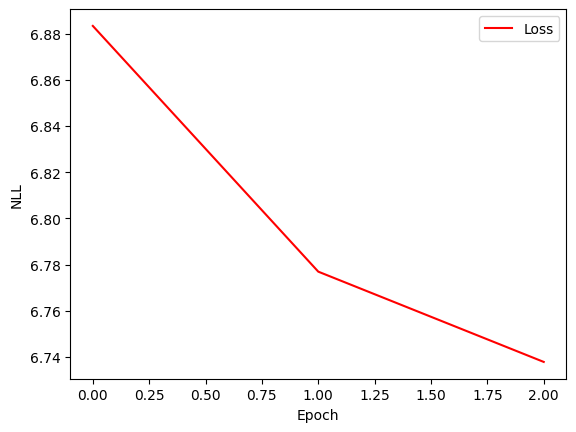

In [27]:
# Graficamos la perdida
epoch_ = np.arange(len(running_loss))
plt.figure()
plt.plot(epoch_, running_loss, 'r', label='Loss',)
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

Bueno, hemos visto la cantidad de tiemp que hay que invertirle para entrenar una red tan sencilla como la que se usa en Wor2Vec. En mi caso, usando CUDA le tomó alrededor de **42 minutos**. Ahora consideren aquel modelo donde no solo se sacan 50 representaciones de cada palabra sino miles, además que se entrenan por más epocas, no solo 3.

Ahora veamos que tipo de palabras son las más cercanas a una pequeña muestra de 4 palabras. Para esto primero necesitamos sacar los pesos del modelo y pasarlos al cpu para trabajarlos como NumPy Arrays. Luego aplicaremos una función para encontrar la distancia dada una métrica (en este caso la distancia del coseno).

In [28]:
wordvecs = model.expand.weight.cpu().detach().numpy()
tokens = ['good', 'bad', 'school', 'day']

In [29]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    # Obtener índice de la palabra en el vocabulario
    idx = tok2id[word]

    # Obtener todas las distancias desde esa palabra
    dists = dist_matrix[idx]

    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

good ['great', 'life', 'one', 'got', 'come', 'us', 'today', 'feel', 'look', 'friend'] 

bad ['chang', 'person', 'die', 'fuck', 'hate', 'tell', 'someth', 'kill', 'talk', 'thought'] 

school ['hour', 'ill', 'meet', 'pay', 'kid', 'book', 'done', 'open', 'big', 'summer'] 

day ['amp', '@user', 'happi', 'love', 'go', 'get', 'im', 'today', 'make', 'time'] 



**PREGUNTAS:**
* ¿Cuál es la implicación del overfitting en modelos como Word2Vec?
* ¿Qué tan bien encontró palabras cercanas su modelo Word2Vec? ¿Podría mejorar? ¿Cómo podría mejorar?
* A grandes rasgos, ¿cuál es la diferencia entre Word2Vec y BERT?

In [30]:

print()
print("La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio")
tick.summarise_marks() #


La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio
